# Unsupervised Learning Capstone
<br>
Colette Gabriel

## Table of Contents:
* [Introduction to the Dataset](#data)
* [Clustering attempts using TF-IDF vectorization](#tfidf)
    - [KNeighbors](#kneigh)
    - [KNN (k++)](#knn)
    - [Affinity Propagation](#aff)
    - [DB Scan](#db)    
* [Clustering attempts using HashingVectorizer](#hash)
    - [MiniBatchMeans](#mini)
    - [Affinity Propagation](#aff2)    
    - [KNN (k++)](#knn2) 

## Introduction to the Dataset  <a name="data"></a>
<br>
The dataset used in this project contains more than 10,000 hotel reviews, consisting of review text plus star rating, plus geographical information for each review. The goal is to use this corpus for sentiment analysis, predicting customer ratings based on text clustering, so I dropped all data except for the review header, review text, and rating columns.
<br><br>
The original data for this project can be downloaded here: 
<br>
Hotel Reviews<br>
https://www.kaggle.com/datafiniti/hotel-reviews/downloads/hotel-reviews.zip/5

In [253]:
import glob
import os
import numpy as np
import pandas as pd
import re
import string
import time
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from contractions import CONTRACTION_MAP
from collections import Counter

#NLP libraries
import nltk
import spacy
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob
#from nltk.tokenize.toktok import ToktokTokenizer
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import sklearn.cluster as cluster
from sklearn.metrics.pairwise import cosine_similarity
>> from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AffinityPropagation
from sklearn.feature_extraction import text

SyntaxError: invalid syntax (<ipython-input-253-bcc92e9194b1>, line 32)

In [183]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)


def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    return word_tokens


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), \
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def tokens(text):
    """get all words from the reviews"""
    return re.findall('[a-z]+', text.lower())
 

def tokenize_spacy(text):
    text_spacy = nlp(text)
  #  sents = np.array(list(text_spacy.sents))
  #  sent_words = [[word.text for word in sent] for sent in sents]
    words = [word.text for word in text_spacy]
    return words
    
    
def clean(text):
    """process the reviews to remove stopwords and punctuation, then perform lemmatization on words"""
#    tokenizer = ToktokTokenizer()
    
    stop_free = " ".join([i for i in text.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    un_acc = remove_accented_chars(normalized)
    contr = expand_contractions(un_acc)
    spec = remove_special_characters(contr)
    blob = TextBlob(spec)
    corr = blob.correct() 
#    final = tokenize_text(corr)
   # final = corr.words
    final_string = str(corr)
    final = tokenize_spacy(final_string)
    final = ' '.join(str(f) for f in final)
    return final

#def tokenize(text):
#    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [3]:
reviews_df = pd.read_csv('/Users/colette/Documents/GitHub/hotel-reviews/Datafiniti_Hotel_Reviews.csv')
reviews_df.head(5)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


In [4]:
reviews_df = reviews_df[['id', 'reviews.text', 'reviews.title', 'reviews.rating']]

In [5]:
#reformat column names to remove the "."
reviews_df = reviews_df.rename(columns={'reviews.text': 'reviews_text'})
reviews_df = reviews_df.rename(columns={'reviews.title': 'reviews_title'})
reviews_df = reviews_df.rename(columns={'reviews.rating': 'reviews_rating'})

In [6]:
#check for missing data
reviews_df.isnull().sum()*100/reviews_df.isnull().count()

total_missing = reviews_df.isnull().sum().sort_values(ascending=False)
percent_missing = (reviews_df.isnull().sum()/reviews_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
reviews_title,1,0.0001
reviews_text,1,0.0001
reviews_rating,0,0.0000
id,0,0.0000


In [7]:
reviews_df.isnull().sum()*100/reviews_df.isnull().count()

id                0.00
reviews_text      0.01
reviews_title     0.01
reviews_rating    0.00
dtype: float64

In [8]:
#number of rows with missing data is small, so drop them
reviews_df = reviews_df.dropna(subset=['reviews_text'])
reviews_df = reviews_df.dropna(subset=['reviews_title'])
reviews_df = reviews_df.dropna(subset=['reviews_rating'])

In [9]:
#create bins for each 1/2 point between ratings, resulting in 9 categories to cluster
reviews_df['rating_bin'] = pd.cut(x=reviews_df['reviews_rating'], bins=[0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [10]:
reviews_df['rating_bin'].unique()

[(4.5, 5.0], (1.5, 2.0], (3.5, 4.0], (2.5, 3.0], (0.0, 1.0], (4.0, 4.5], (2.0, 2.5], (3.0, 3.5], (1.0, 1.5]]
Categories (9, interval[float64]): [(0.0, 1.0] < (1.0, 1.5] < (1.5, 2.0] < (2.0, 2.5] ... (3.0, 3.5] < (3.5, 4.0] < (4.0, 4.5] < (4.5, 5.0]]

In [184]:
#run all reviews through the clean text function
start_time = time.time()

reviews_df['reviews_clean2'] = reviews_df['reviews_text'].apply(lambda x:clean(x))
reviews_df['reviews_clean_title2'] = reviews_df['reviews_title'].apply(lambda x:clean(x))

#join review text + title text into one bag of words for clustering analysis
reviews_df['clean2'] = reviews_df['reviews_clean'] + ' ' + reviews_df['reviews_clean_title']

#reviews_df['clean'] = reviews_df['clean'].apply(lambda x:tokenize_text(x))
print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

--- 4347.58 seconds ---


In [192]:
#clean is a combined field of reviews text and title cleaned and tokenized with TextBlob Word
#clean2 is a combined field of reviews text and title cleaned and tokenized with Spacy

#in both cases, the vector field was reduced from 22,000+ to < 5,100 through spell check and other cleaning methods
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 13 columns):
id                      9998 non-null object
reviews_text            9998 non-null object
reviews_title           9998 non-null object
reviews_rating          9998 non-null float64
rating_bin              9998 non-null category
reviews_clean           9998 non-null object
reviews_clean_title     9998 non-null object
clean                   9998 non-null object
kmeans_cluster          9998 non-null int32
affprop_cluster         9998 non-null int64
reviews_clean2          9998 non-null object
reviews_clean_title2    9998 non-null object
clean2                  9998 non-null object
dtypes: category(1), float64(1), int32(1), int64(1), object(9)
memory usage: 1.3+ MB


In [185]:
reviews_df['reviews_clean2'][455]

'bad room size good location'

## Clustering attempts using TF-IDF vectorization <a name="tfidf"></a>

In [197]:
count_vect = CountVectorizer(ngram_range=(1, 3), min_df=10, max_df=0.8, stop_words='english')
transformer = TfidfTransformer()
le = preprocessing.LabelEncoder()


X = reviews_df['clean2']
y = le.fit_transform(reviews_df['rating_bin']) #label encoding on the 9 binned categories

X_counts = count_vect.fit_transform(X)
X = transformer.fit_transform(X_counts)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print(f'Shape of Term Frequency Matrix: {X_counts.shape}')
print(f'Shape of TFIDF Matrix: {X.shape}')
print(f'Shape of y: {y_train.shape}')

The number of observations in training set is 6698
The number of observations in test set is 3300
Shape of Term Frequency Matrix: (9998, 5488)
Shape of TFIDF Matrix: (9998, 5488)
Shape of y: (6698,)


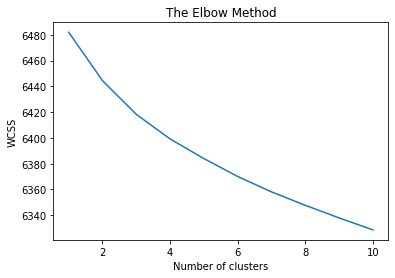

--- 597.04 seconds ---


In [40]:
start_time = time.time()

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=100,n_init=10,random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
        
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

### KNeighbors <a name="kneigh"></a>

In [199]:
start_time = time.time()

num_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
# Clustering the document with KNN classifier

for num in num_clusters:
    modelknn = KNeighborsClassifier(n_neighbors=num)
    modelknn.fit(X_train, y_train)
    print("Silhouette Coefficient: {}".format(metrics.silhouette_score(X_test, y_pred)))

print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

number of clusters = 2, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 3, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 4, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 5, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 6, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 7, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 8, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
number of clusters = 9, accuracy = 0.5015151515151515
Silhouette Coefficient: -0.003967271846686156
--- 2.64 seconds ---


### KMeans (k++) <a name="knn"></a>

In [91]:
start_time = time.time()
print('working')

X = reviews_df['clean']

count_vect = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words='english')
cv_matrix = count_vect.fit_transform(X)
cv_matrix.shape

num_clusters = 9

km = KMeans(n_clusters=num_clusters, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
labels = km.labels_

print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

working
--- 477.78 seconds ---


In [96]:
Counter(km.labels_)

Counter({5: 3091,
         0: 822,
         7: 966,
         8: 1172,
         4: 1481,
         2: 1260,
         1: 869,
         6: 210,
         3: 127})

In [98]:
feature_names = count_vect.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [99]:
# get key features for each cluster
# get reviews belonging to each cluster
for cluster_num in range(num_clusters):
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
    reviews = reviews_df[reviews_df['kmeans_cluster'] == cluster_num]['reviews_rating'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Ratings:', reviews)
    print('-'*80)

CLUSTER #1
Key Features: ['stay', 'hotel', 'room', 'great', 'place', 'nice', 'staff', 'clean', 'good', 'breakfast', 'place stay', 'time', 'comfortable', 'night', 'friendly']
Popular Ratings: [5.0, 5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.6, 2.7, 5.0, 4.6, 4.8, 5.0, 4.0, 5.0, 4.8, 4.4, 1.45, 4.8, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.6, 3.55, 5.0, 2.5, 4.15, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 4.0, 2.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 1.0, 1.0, 2.0, 4.0, 4.0, 2.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 1.0, 

In [124]:
start_time = time.time()
print('working')

cosine_sim_features = cosine_similarity(cv_matrix)

km = KMeans(n_clusters=num_clusters, max_iter=10000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)
   
print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

working
--- 678.79 seconds ---


In [125]:
reviews_df['kmeans_cluster'] = km.labels_

reviews_clusters = (reviews_df[['reviews_clean', 'reviews_clean_title', 'kmeans_cluster', 'reviews_rating']]
                  .sort_values(by=['kmeans_cluster', 'reviews_rating'],
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
reviews_clusters = reviews_clusters.copy(deep=True)

In [132]:
for cluster_num in range(num_clusters):
    reviews = review_clusters[review_clusters['kmeans_cluster'] == cluster_num]['reviews_title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Popular Ratings:', reviews)
    print('-'*80)

CLUSTER #1
Popular Ratings: ['ALWAYS GREAT STAY...', 'great!!!!!!', 'Extremely comfortable', 'A fun place to stay with great staff and lots going on in...', 'Fun place and great staff', 'Dont look past The Boxer for Boston accommodation.', 'Great location for a reasonable price in Boston.', 'Dont look past The Boxer for Boston accommodation.', 'What a great experience!', 'Great find in Boston', 'Modern style, great location, super helpful staff,...', 'Wonderful great city and the hotel was in the perfect location', 'great location breakfast', 'Everything about this place was great!', "It's economical, boutique style (my fave), great quality...", 'a Boston great!', 'Loved it....Location and Friendly Staff!!!', 'Great value.', 'Another lovely night', 'Great Customer Service']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Ratings: ['Worth the money', 'Amazing employees and facilities', 'Excellent!', 'Great Room', 'Happy in Texas.', 'Fr

### Affinity Propagation <a name="aff"></a>

In [108]:
start_time = time.time()
print('working')

ap = AffinityPropagation(max_iter=1000)
ap.fit(cosine_sim_features)
labels = af.labels_
res = Counter(ap.labels_)
res.most_common(10)

print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

working
--- 232.22 seconds ---


In [110]:
reviews_df['affprop_cluster'] = ap.labels_
filtered_clusters = [item[0] for item in res.most_common(8)]
filtered_df = reviews_df[reviews_df['affprop_cluster'].isin(filtered_clusters)]
reviews_clusters = (filtered_df[['reviews_title', 'reviews_text', 'affprop_cluster', 'reviews_rating']]
                  .sort_values(by=['affprop_cluster', 'reviews_rating'],
                               ascending=False)
                  .groupby('affprop_cluster').head(20))
reviews_clusters = reviews_clusters.copy(deep=True)

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(len(filtered_clusters)):
    reviews = reviews_clusters[reviews_clusters['affprop_cluster'] \
                               == filtered_clusters[cluster_num]]['reviews_title'].values.tolist()
    print('CLUSTER #'+str(filtered_clusters[cluster_num]))
    print('Popular Movies:', reviews)
    print('-'*80)

CLUSTER #213
Popular Movies: ['Didnt smell like smoke, and no gambling', 'Fancy', 'It was very close to the airport', 'second visit amazing', 'All We Lacked Was Sunshine', 'Front desk', 'Business Trip', 'Scalloping with Capt. Russ is our families favorite activity!', 'Quiet getaway', 'Best vacation ever', 'Outstanding Attention to Detail!', 'In the Heart of Silver Spring', 'Simply Paradise', 'We would return to stay at Honua Kai', 'Everything was fine!', 'Me encantaron mis vacaciones pasarlas en ese lugar', 'Cheer Competition', 'Just Lovely', 'Fun filled 36 hours', 'Nadia is the best!']
--------------------------------------------------------------------------------
CLUSTER #287
Popular Movies: ['Amazing Experience', 'Awesome Birthday Night!', 'Best in Winfield!', 'Family, convention, wedding, product launch', 'The best modern resort In Vegas!', 'Lovely Resort', '52 SECOND ANNIVESARY', 'Exceeded Expectations', 'When I booked my room it said that that parking was included...', 'Standard

### DB Scan <a name="db"></a>

In [182]:
start_time = time.time()

print('working...')

db = DBSCAN(eps= 8, min_samples= 3).fit(cv_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


print("--- %s seconds ---" % round(time.time() - start_time, 2))

print("Silhouette Coefficient: {}".format(metrics.silhouette_score(cv_matrix, labels)))

working...
[0 0 0 ... 0 0 0]
Estimated number of clusters: 1
Estimated number of noise points: 913
--- 3.92 seconds ---
Silhouette Coefficient: 0.31676051267216976


## Clustering attempts using HashingVectorizer <a name="hash"></a>

In [228]:
le = preprocessing.LabelEncoder()
hasher = HashingVectorizer(stop_words='english', alternate_sign=False, norm='l2', binary=False)

X = reviews_df['clean2']
y = le.fit_transform(reviews_df['rating_bin']) #label encoding on the 9 binned categories

X = hasher.fit_transform(X)
#X_counts = count_vect.fit_transform(X)
X = transformer.fit_transform(X_counts)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print(f'Shape of Term Frequency Matrix: {X_counts.shape}')
print(f'Shape of TFIDF Matrix: {X.shape}')
print(f'Shape of y: {y_train.shape}')

The number of observations in training set is 6698
The number of observations in test set is 3300
Shape of Term Frequency Matrix: (9998, 5488)
Shape of TFIDF Matrix: (9998, 5488)
Shape of y: (6698,)


In [229]:
start_time = time.time()

print('working...')
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(2500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()

print("--- %s seconds ---" % round(time.time() - start_time, 2))


print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

working...
Performing dimensionality reduction using LSA
--- 29.62 seconds ---
Explained variance of the SVD step: 88%


### MiniBatchMeans <a name="mini"></a>

In [231]:
start_time = time.time()

print('working...')

km = MiniBatchKMeans(n_clusters=9, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)

print("Clustering sparse data with %s" % km)
km.fit(X)

print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

working...
Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=9, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)
Init 1/1 with method: k-means++
Inertia for init 1/1: 954.341909
Minibatch iteration 1/1000: mean batch inertia: 0.966285, ewa inertia: 0.966285 
Minibatch iteration 2/1000: mean batch inertia: 0.961412, ewa inertia: 0.965310 
Minibatch iteration 3/1000: mean batch inertia: 0.959239, ewa inertia: 0.964096 
Minibatch iteration 4/1000: mean batch inertia: 0.959256, ewa inertia: 0.963128 
Minibatch iteration 5/1000: mean batch inertia: 0.958842, ewa inertia: 0.962270 
Minibatch iteration 6/1000: mean batch inertia: 0.957305, ewa inertia: 0.961277 
Minibatch iteration 7/1000: mean batch inertia: 0.956787, ewa inertia: 0.960379 
Minibatch iteration 8/1000: mean batch inertia: 0.956047, ewa ine

### Affinity Propagation <a name="aff2"></a>

In [264]:
sns.set_context('poster')
sns.set_color_codes()

def plot_clusters(data, algorithm, args, kwds):
    plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
    
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=12)
    
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels, sample_size=1000))
    print("Calinski-Harabasz Index: %0.3f" % metrics.calinski_harabasz_score(data, labels))

Silhouette Coefficient: 0.000
Calinski-Harabasz Index: 0.963


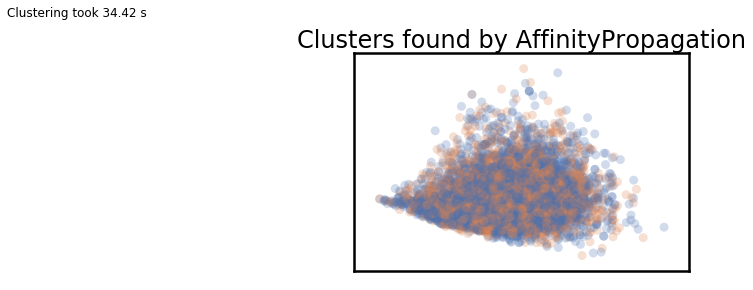

In [265]:
plot_clusters(X, AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

### KMeans (k++) <a name="knn2"></a>

In [267]:
start_time = time.time()
print('working')

num_clusters = 9

km = KMeans(n_clusters=num_clusters, max_iter=10000, random_state=42).fit(cv_matrix)
labels = km.labels_

print("--- {} seconds ---".format(round(time.time() - start_time, 2)))

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))
print("Calinski-Harabasz Index: %0.3f" % metrics.calinski_harabasz_score(X, km.labels_))

working
--- 89.02 seconds ---
Silhouette Coefficient: -0.004
Calinski-Harabasz Index: 18.076
